<a href="https://colab.research.google.com/github/euniceky/YogaPoseDetection/blob/master/Torch_Inception_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division
import os
import time
import copy


import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Preprocessing, Image Augmenation

In [0]:
# Transform train, validation, and test data
# Need the image to be of size 224,224,3
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(30),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # ImageNet standards
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [0]:

# Set the directory path for train, validation, and test image folders
data_dir = '/content/drive/My Drive/'

# ImageFolder takes a set of images and return a set of transformed images 
# This part is done per class (train/val/test)
# Datasets can be passed onto Dataloaders in the next step
# There are two kinds of datasets, map-style and iterable-style.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val','test']}


In [5]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
print(dataset_sizes)
print(class_names)
# Only ~1200 photos

{'train': 824, 'val': 231, 'test': 117}
['Dolphin', 'DownwardDog', 'Sphinx', 'UpwardDog']


In [0]:
# A dictionary of Dataloaders for each of train, validation, test
# This is in the right format to feed to the model
# Current batch size = 8 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}


# Helper functions to train, test, and visualize images.

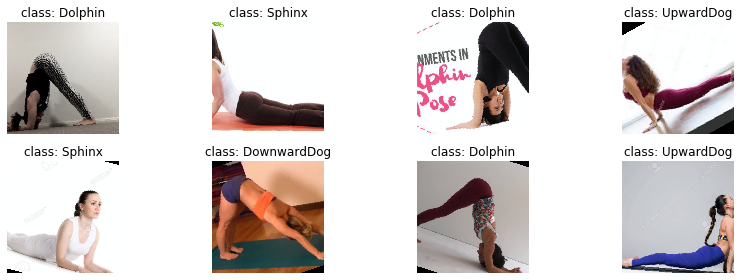

In [7]:
def imshow(img, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # Without this step, it shows normalized (not true colors) images
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)

# Get a batch of **training** data (batch size is currenlty = 8)
inputs, classes = next(iter(dataloaders['train']))

# New visualization to make it look better
plt.subplots(figsize=(12,4))
images_so_far = 0 
for j in range(inputs.size()[0]):
    images_so_far += 1
    ax = plt.subplot(2, 4, images_so_far)
    ax.axis('off')
    ax.set_title('class: {}'.format(class_names[classes[j]]))
    imshow(inputs.cpu().data[j])


plt.tight_layout()


In [0]:
# A function for training

def train_model(model, criterion, optimizer, scheduler, loss_train, loss_val, acc_train, acc_val, num_epochs=25):
    since = time.time()

    # there are many ways to make copies for example: 
    # newmodel = model.clone().detach()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase =='train':
              loss_train.append(epoch_loss)
              acc_train.append(epoch_acc)
            else:
              loss_val.append(epoch_loss)
              acc_val.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [0]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    
    plt.subplots(figsize=(12,4))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, 4, images_so_far)
                ax.axis('off')
                ax.set_title('pred: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
def test(model, criterion):
    # since =time.time()
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # calculate the loss
        loss = criterion(outputs, labels)
        # update average test loss 
        test_loss += loss.item() * inputs.size(0)
        correct += torch.sum(preds == labels.data)

    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %.4f%% (%2d/%2d)' % (
        100. * correct / dataset_sizes["test"], correct, dataset_sizes["test"]))
    
    #time_elapsed = time.time() - since
    #print('Training complete in {:.0f}m {:.0f}s'.format(
        #time_elapsed // 60, time_elapsed % 60))

# Results



### 1. Resnet 50: fine-tuning


In [0]:
model_res50 = models.resnet50(pretrained=True)
# model_res50 = model_res50.to(device)
# summary(model_res50, (3, 224, 224))
num_ftrs = model_res50.fc.in_features
model_res50.fc = nn.Linear(num_ftrs, len(class_names))
model_res50 = model_res50.to(device)

In [22]:
# Decay LR by a factor of 0.1 every 5 epochs
criterion = nn.CrossEntropyLoss()
optimizer_res50 = optim.SGD(model_res50.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_res50, step_size=5, gamma=0.1)

loss_train_res50=[]
loss_val_res50=[]
acc_train_res50=[]
acc_val_res50=[]

# Train
model_res50 = train_model(model_res50, criterion, optimizer_res50, exp_lr_scheduler,
                       num_epochs=20, loss_train=loss_train_res50, loss_val=loss_val_res50, acc_train=acc_train_res50, acc_val=acc_val_res50)
# Test
test(model_res50, criterion)


Epoch 0/19
----------
train Loss: 0.9971 Acc: 0.5789
val Loss: 0.6026 Acc: 0.6970

Epoch 1/19
----------
train Loss: 0.4898 Acc: 0.7876
val Loss: 0.2409 Acc: 0.9091

Epoch 2/19
----------
train Loss: 0.3638 Acc: 0.8629
val Loss: 0.2001 Acc: 0.9394

Epoch 3/19
----------
train Loss: 0.3293 Acc: 0.8774
val Loss: 0.2129 Acc: 0.9177

Epoch 4/19
----------
train Loss: 0.2233 Acc: 0.9381
val Loss: 0.1529 Acc: 0.9437

Epoch 5/19
----------
train Loss: 0.1480 Acc: 0.9575
val Loss: 0.1759 Acc: 0.9351

Epoch 6/19
----------
train Loss: 0.1677 Acc: 0.9490
val Loss: 0.1443 Acc: 0.9481

Epoch 7/19
----------
train Loss: 0.1331 Acc: 0.9624
val Loss: 0.1444 Acc: 0.9524

Epoch 8/19
----------
train Loss: 0.1044 Acc: 0.9636
val Loss: 0.1498 Acc: 0.9524

Epoch 9/19
----------
train Loss: 0.1616 Acc: 0.9405
val Loss: 0.1660 Acc: 0.9264

Epoch 10/19
----------
train Loss: 0.1365 Acc: 0.9466
val Loss: 0.1490 Acc: 0.9567

Epoch 11/19
----------
train Loss: 0.1063 Acc: 0.9697
val Loss: 0.1480 Acc: 0.9437

Ep

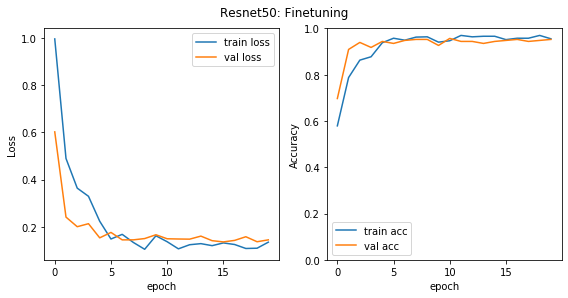

In [26]:
# Save
model_save_name = "resnet50.pt"
path = "/content/drive/My Drive/{model_save_name}"
torch.save(model_res50.state_dict(), path)
# model.load_state_dict(torch.load('yoga.pt'))

# Plot
plt.subplots(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(loss_train_res50, label="train loss")
plt.plot(loss_val_res50, label="val loss")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_train_res50, label="train acc")
plt.plot(acc_val_res50, label="val acc")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.tight_layout()
plt.suptitle("Resnet50: Finetuning", va="bottom")
plt.show()

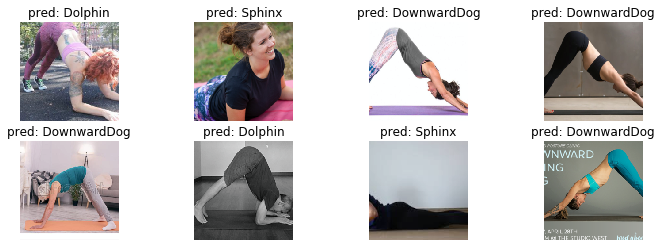

In [24]:
visualize_model(model_res50)

#### 2. Resnet50: Feature Extraction

In [0]:
model_res50_fz = models.resnet50(pretrained=True)
for param in model_res50_fz.parameters():
  param.requires_grad = False

num_ftrs = model_res50_fz.fc.in_features
model_res50_fz.fc = nn.Linear(num_ftrs, len(class_names))
model_res50_fz = model_res50_fz.to(device)

In [28]:
# Decay LR by a factor of 0.1 every 5 epochs
criterion = nn.CrossEntropyLoss()
optimizer_res50_fz = optim.SGD(model_res50_fz.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_res50_fz, step_size=5, gamma=0.1)

loss_train_res50_fz=[]
loss_val_res50_fz=[]
acc_train_res50_fz=[]
acc_val_res50_fz=[]

# Train
model_res50_fz = train_model(model_res50_fz, criterion, optimizer_res50_fz, exp_lr_scheduler,
                       num_epochs=20, loss_train=loss_train_res50_fz, loss_val=loss_val_res50_fz, acc_train=acc_train_res50_fz, acc_val=acc_val_res50_fz)

# Test 
test(model_res50_fz, criterion)



Epoch 0/19
----------
train Loss: 1.1916 Acc: 0.4490
val Loss: 0.8269 Acc: 0.7186

Epoch 1/19
----------
train Loss: 0.8987 Acc: 0.6335
val Loss: 0.8262 Acc: 0.6623

Epoch 2/19
----------
train Loss: 0.8984 Acc: 0.6117
val Loss: 0.6722 Acc: 0.7316

Epoch 3/19
----------
train Loss: 0.7167 Acc: 0.7172
val Loss: 0.6579 Acc: 0.7013

Epoch 4/19
----------
train Loss: 0.7192 Acc: 0.7209
val Loss: 0.6044 Acc: 0.7706

Epoch 5/19
----------
train Loss: 0.6247 Acc: 0.7803
val Loss: 0.6189 Acc: 0.7576

Epoch 6/19
----------
train Loss: 0.6144 Acc: 0.7670
val Loss: 0.6123 Acc: 0.7576

Epoch 7/19
----------
train Loss: 0.6543 Acc: 0.7330
val Loss: 0.6160 Acc: 0.7619

Epoch 8/19
----------
train Loss: 0.6170 Acc: 0.7803
val Loss: 0.6095 Acc: 0.7619

Epoch 9/19
----------
train Loss: 0.6370 Acc: 0.7585
val Loss: 0.6022 Acc: 0.7662

Epoch 10/19
----------
train Loss: 0.6103 Acc: 0.7852
val Loss: 0.6076 Acc: 0.7706

Epoch 11/19
----------
train Loss: 0.6198 Acc: 0.7706
val Loss: 0.6057 Acc: 0.7532

Ep

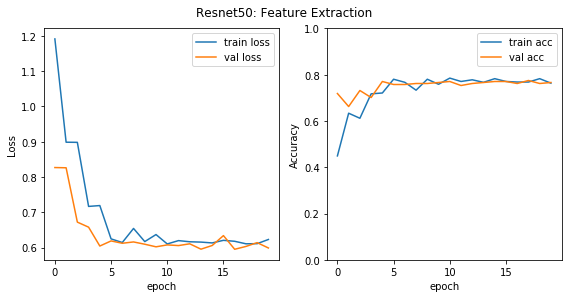

In [67]:
# Save
model_save_name = "resnet50_fz.pt"
path = "/content/drive/My Drive/{model_save_name}"
torch.save(model_res50_fz.state_dict(), path)

# Plot
plt.subplots(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(loss_train_res50_fz, label="train loss")
plt.plot(loss_val_res50_fz, label="val loss")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_train_res50_fz, label="train acc")
plt.plot(acc_val_res50_fz, label="val acc")
plt.legend()
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.tight_layout()
plt.suptitle("Resnet50: Feature Extraction", va="bottom")
plt.show()

#### 3. Resnet18: Fine-tuning

In [30]:
model_res18 = models.resnet18(pretrained=True)

num_ftrs = model_res18.fc.in_features
model_res18.fc = nn.Linear(num_ftrs, len(class_names))
model_res18 = model_res18.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 38.9MB/s]


In [31]:
# Decay LR by a factor of 0.1 every 5 epochs
criterion = nn.CrossEntropyLoss()
optimizer_res18 = optim.SGD(model_res18.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_res18, step_size=5, gamma=0.1)

loss_train_res18=[]
loss_val_res18=[]
acc_train_res18=[]
acc_val_res18=[]

# Train
model_res18 = train_model(model_res18, criterion, optimizer_res18, exp_lr_scheduler,
                       num_epochs=20, loss_train=loss_train_res18, loss_val=loss_val_res18, acc_train=acc_train_res18, acc_val=acc_val_res18)
# Test
test(model_res18, criterion)


Epoch 0/19
----------
train Loss: 0.9700 Acc: 0.5680
val Loss: 0.5460 Acc: 0.7576

Epoch 1/19
----------
train Loss: 0.5411 Acc: 0.7767
val Loss: 0.2659 Acc: 0.9134

Epoch 2/19
----------
train Loss: 0.4414 Acc: 0.8386
val Loss: 0.2866 Acc: 0.8788

Epoch 3/19
----------
train Loss: 0.3250 Acc: 0.8701
val Loss: 0.3224 Acc: 0.8745

Epoch 4/19
----------
train Loss: 0.2702 Acc: 0.8981
val Loss: 0.2591 Acc: 0.9004

Epoch 5/19
----------
train Loss: 0.2513 Acc: 0.9041
val Loss: 0.1928 Acc: 0.9134

Epoch 6/19
----------
train Loss: 0.2049 Acc: 0.9199
val Loss: 0.2010 Acc: 0.9351

Epoch 7/19
----------
train Loss: 0.1643 Acc: 0.9430
val Loss: 0.1859 Acc: 0.9177

Epoch 8/19
----------
train Loss: 0.1679 Acc: 0.9478
val Loss: 0.1924 Acc: 0.9177

Epoch 9/19
----------
train Loss: 0.1487 Acc: 0.9575
val Loss: 0.1881 Acc: 0.9264

Epoch 10/19
----------
train Loss: 0.1273 Acc: 0.9624
val Loss: 0.1902 Acc: 0.9307

Epoch 11/19
----------
train Loss: 0.1642 Acc: 0.9430
val Loss: 0.1865 Acc: 0.9394

Ep

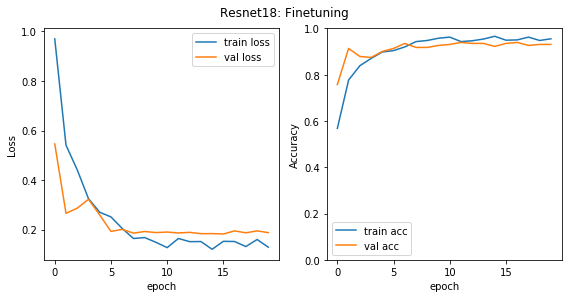

In [66]:
# Save
model_save_name = "resnet18.pt"
path = "/content/drive/My Drive/{model_save_name}"
torch.save(model_res18.state_dict(), path)
# model.load_state_dict(torch.load('yoga.pt'))

# Plot
plt.subplots(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(loss_train_res18, label="train loss")
plt.plot(loss_val_res18, label="val loss")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_train_res18, label="train acc")
plt.plot(acc_val_res18, label="val acc")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.tight_layout()
plt.suptitle("Resnet18: Finetuning", va="bottom")
plt.show()

#### 4. Resnet18: Feature Extraction 

In [0]:
model_res18_fz = models.resnet18(pretrained=True)
for param in model_res18_fz.parameters():
  param.requires_grad = False

num_ftrs = model_res18_fz.fc.in_features
model_res18_fz.fc = nn.Linear(num_ftrs, len(class_names))
model_res18_fz = model_res18_fz.to(device)

In [34]:
# Decay LR by a factor of 0.1 every 5 epochs
criterion = nn.CrossEntropyLoss()
optimizer_res18_fz = optim.SGD(model_res18_fz.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_res18_fz, step_size=5, gamma=0.1)

loss_train_res18_fz=[]
loss_val_res18_fz=[]
acc_train_res18_fz=[]
acc_val_res18_fz=[]

# Train
model_res18_fz = train_model(model_res18_fz, criterion, optimizer_res18_fz, exp_lr_scheduler,
                       num_epochs=20, loss_train=loss_train_res18_fz, loss_val=loss_val_res18_fz, acc_train=acc_train_res18_fz, acc_val=acc_val_res18_fz)

# Test 
test(model_res18_fz, criterion)


Epoch 0/19
----------
train Loss: 1.1664 Acc: 0.4624
val Loss: 0.8102 Acc: 0.6797

Epoch 1/19
----------
train Loss: 0.8863 Acc: 0.6311
val Loss: 0.6496 Acc: 0.7835

Epoch 2/19
----------
train Loss: 0.8091 Acc: 0.6614
val Loss: 0.6295 Acc: 0.6970

Epoch 3/19
----------
train Loss: 0.7131 Acc: 0.7063
val Loss: 0.5717 Acc: 0.7403

Epoch 4/19
----------
train Loss: 0.6786 Acc: 0.7184
val Loss: 0.5515 Acc: 0.7922

Epoch 5/19
----------
train Loss: 0.6266 Acc: 0.7549
val Loss: 0.5362 Acc: 0.7879

Epoch 6/19
----------
train Loss: 0.6115 Acc: 0.7658
val Loss: 0.5341 Acc: 0.7706

Epoch 7/19
----------
train Loss: 0.5998 Acc: 0.7803
val Loss: 0.5364 Acc: 0.7835

Epoch 8/19
----------
train Loss: 0.6243 Acc: 0.7512
val Loss: 0.5314 Acc: 0.7922

Epoch 9/19
----------
train Loss: 0.6068 Acc: 0.7585
val Loss: 0.5346 Acc: 0.7749

Epoch 10/19
----------
train Loss: 0.5798 Acc: 0.7658
val Loss: 0.5358 Acc: 0.7792

Epoch 11/19
----------
train Loss: 0.6140 Acc: 0.7524
val Loss: 0.5279 Acc: 0.7576

Ep

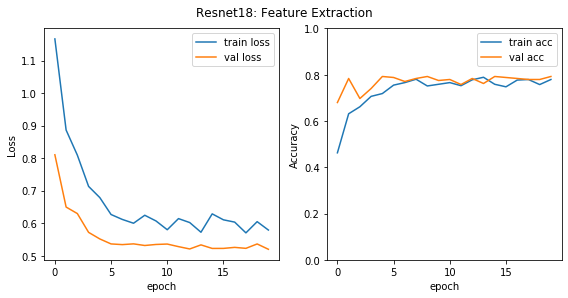

In [65]:
# Save
model_save_name = "resnet18_fz.pt"
path = "/content/drive/My Drive/{model_save_name}"
torch.save(model_res18_fz.state_dict(), path)

# Plot
plt.subplots(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(loss_train_res18_fz, label="train loss")
plt.plot(loss_val_res18_fz, label="val loss")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_train_res18_fz, label="train acc")
plt.plot(acc_val_res18_fz, label="val acc")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.tight_layout()
plt.suptitle("Resnet18: Feature Extraction", va="bottom")
plt.show()

### 5. Resnet18: Training several top layers

In [0]:
model_res18_sev = models.resnet18(pretrained=True)
for param in model_res18_sev.parameters():
  param.requires_grad = False

model_res18_sev.layer4[0].conv1.weight.requires_grad=True
model_res18_sev.layer4[0].bn1.weight.requires_grad=True
model_res18_sev.layer4[0].conv2.weight.requires_grad=True
model_res18_sev.layer4[0].bn2.weight.requires_grad=True
model_res18_sev.layer4[0].downsample[0].weight.requires_grad=True
model_res18_sev.layer4[0].downsample[1].weight.requires_grad=True

model_res18_sev.layer4[1].conv1.weight.requires_grad=True
model_res18_sev.layer4[1].bn1.weight.requires_grad=True
model_res18_sev.layer4[1].conv2.weight.requires_grad=True
model_res18_sev.layer4[1].bn2.weight.requires_grad=True


num_ftrs = model_res18_sev.fc.in_features
model_res18_sev.fc = nn.Linear(num_ftrs, len(class_names))
model_res18_sev = model_res18_sev.to(device)

In [37]:
# Decay LR by a factor of 0.1 every 5 epochs
criterion = nn.CrossEntropyLoss()
optimizer_res18_sev = optim.SGD(model_res18_sev.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_res18_sev, step_size=5, gamma=0.1)

loss_train_res18_sev=[]
loss_val_res18_sev=[]
acc_train_res18_sev=[]
acc_val_res18_sev=[]

# Train
model_res18_sev = train_model(model_res18_sev, criterion, optimizer_res18_sev, exp_lr_scheduler,
                       num_epochs=20, loss_train=loss_train_res18_sev, loss_val=loss_val_res18_sev, acc_train=acc_train_res18_sev, acc_val=acc_val_res18_sev)

# Test 
test(model_res18_sev, criterion)


Epoch 0/19
----------
train Loss: 1.0339 Acc: 0.5413
val Loss: 0.5239 Acc: 0.7662

Epoch 1/19
----------
train Loss: 0.6621 Acc: 0.7233
val Loss: 0.4539 Acc: 0.7879

Epoch 2/19
----------
train Loss: 0.4652 Acc: 0.8265
val Loss: 0.3639 Acc: 0.8225

Epoch 3/19
----------
train Loss: 0.3659 Acc: 0.8507
val Loss: 0.3487 Acc: 0.8615

Epoch 4/19
----------
train Loss: 0.3429 Acc: 0.8617
val Loss: 0.3378 Acc: 0.8658

Epoch 5/19
----------
train Loss: 0.2993 Acc: 0.8981
val Loss: 0.3488 Acc: 0.8571

Epoch 6/19
----------
train Loss: 0.2604 Acc: 0.9066
val Loss: 0.3488 Acc: 0.8615

Epoch 7/19
----------
train Loss: 0.2517 Acc: 0.9066
val Loss: 0.3116 Acc: 0.8658

Epoch 8/19
----------
train Loss: 0.2786 Acc: 0.9005
val Loss: 0.3277 Acc: 0.8615

Epoch 9/19
----------
train Loss: 0.2483 Acc: 0.9126
val Loss: 0.2899 Acc: 0.8788

Epoch 10/19
----------
train Loss: 0.2172 Acc: 0.9223
val Loss: 0.3420 Acc: 0.8658

Epoch 11/19
----------
train Loss: 0.2426 Acc: 0.9090
val Loss: 0.2949 Acc: 0.8874

Ep

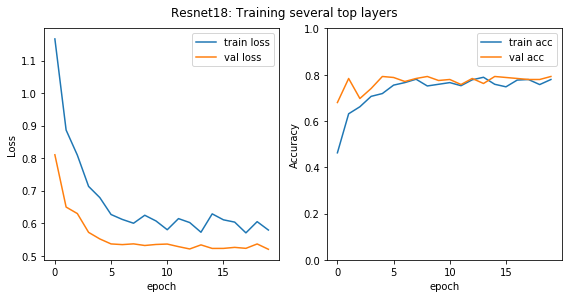

In [64]:
# Save
model_save_name = "resnet18_sev.pt"
path = "/content/drive/My Drive/{model_save_name}"
torch.save(model_res18_sev.state_dict(), path)

# Plot
plt.subplots(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(loss_train_res18_fz, label="train loss")
plt.plot(loss_val_res18_fz, label="val loss")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_train_res18_fz, label="train acc")
plt.plot(acc_val_res18_fz, label="val acc")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.tight_layout()
plt.suptitle("Resnet18: Training several top layers", va="bottom")
plt.show()

### 6. Resnet18: finetuning using SVM 

In [0]:
model_res18_svm = models.resnet18(pretrained=True)
num_ftrs = model_res18_svm.fc.in_features
model_res18_svm.fc = nn.Linear(num_ftrs, len(class_names))
model_res18_svm = model_res18_svm.to(device)

In [40]:
# Decay LR by a factor of 0.1 every 5 epochs
criterion = nn.MultiMarginLoss()
optimizer_res18_svm = optim.SGD(model_res18_svm.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_res18_svm, step_size=5, gamma=0.1)

loss_train_res18_svm=[]
loss_val_res18_svm=[]
acc_train_res18_svm=[]
acc_val_res18_svm=[]

# Train
model_res18_svm = train_model(model_res18_svm, criterion, optimizer_res18_svm, exp_lr_scheduler,
                       num_epochs=20, loss_train=loss_train_res18_svm, loss_val=loss_val_res18_svm, acc_train=acc_train_res18_svm, acc_val=acc_val_res18_svm)

# Test 
test(model_res18_svm, criterion)


Epoch 0/19
----------
train Loss: 0.4214 Acc: 0.5316
val Loss: 0.1597 Acc: 0.7489

Epoch 1/19
----------
train Loss: 0.2049 Acc: 0.7488
val Loss: 0.1086 Acc: 0.8139

Epoch 2/19
----------
train Loss: 0.1431 Acc: 0.7961
val Loss: 0.0953 Acc: 0.8355

Epoch 3/19
----------
train Loss: 0.1331 Acc: 0.8204
val Loss: 0.1099 Acc: 0.8225

Epoch 4/19
----------
train Loss: 0.1144 Acc: 0.8410
val Loss: 0.0823 Acc: 0.8701

Epoch 5/19
----------
train Loss: 0.0767 Acc: 0.8944
val Loss: 0.0800 Acc: 0.8831

Epoch 6/19
----------
train Loss: 0.0777 Acc: 0.8859
val Loss: 0.0892 Acc: 0.8658

Epoch 7/19
----------
train Loss: 0.0751 Acc: 0.9066
val Loss: 0.0794 Acc: 0.8874

Epoch 8/19
----------
train Loss: 0.0621 Acc: 0.9114
val Loss: 0.0776 Acc: 0.8961

Epoch 9/19
----------
train Loss: 0.0759 Acc: 0.8956
val Loss: 0.0782 Acc: 0.8788

Epoch 10/19
----------
train Loss: 0.0669 Acc: 0.9163
val Loss: 0.0784 Acc: 0.8701

Epoch 11/19
----------
train Loss: 0.0611 Acc: 0.9199
val Loss: 0.0747 Acc: 0.8961

Ep

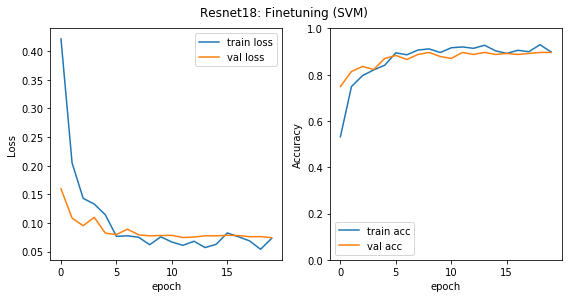

In [63]:
# Save
model_save_name = "resnet18_svm.pt"
path = "/content/drive/My Drive/{model_save_name}"
torch.save(model_res18_svm.state_dict(), path)

# Plot
plt.subplots(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(loss_train_res18_svm, label="train loss")
plt.plot(loss_val_res18_svm, label="val loss")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_train_res18_svm, label="train acc")
plt.plot(acc_val_res18_svm, label="val acc")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.tight_layout()
plt.suptitle("Resnet18: Finetuning (SVM)", va="bottom")
plt.show()

### 7. Resnet18: feature extraction using SVM 

In [0]:
model_res18_fz_svm = models.resnet18(pretrained=True)
for param in model_res18_fz_svm.parameters():
  param.requires_grad = False

num_ftrs = model_res18_fz_svm.fc.in_features
model_res18_fz_svm.fc = nn.Linear(num_ftrs, len(class_names))
model_res18_fz_svm = model_res18_fz_svm.to(device)

In [43]:
# Decay LR by a factor of 0.1 every 5 epochs
criterion = nn.MultiMarginLoss()
optimizer_res18_fz_svm = optim.SGD(model_res18_fz_svm.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_res18_fz_svm, step_size=5, gamma=0.1)

loss_train_res18_fz_svm=[]
loss_val_res18_fz_svm=[]
acc_train_res18_fz_svm=[]
acc_val_res18_fz_svm=[]

# Train
model_res18_svm = train_model(model_res18_fz_svm, criterion, optimizer_res18_fz_svm, exp_lr_scheduler,
                       num_epochs=20, loss_train=loss_train_res18_fz_svm, loss_val=loss_val_res18_fz_svm, acc_train=acc_train_res18_fz_svm, acc_val=acc_val_res18_fz_svm)

# Test 
test(model_res18_fz_svm, criterion)


Epoch 0/19
----------
train Loss: 0.5295 Acc: 0.4636
val Loss: 0.3196 Acc: 0.6883

Epoch 1/19
----------
train Loss: 0.3645 Acc: 0.5983
val Loss: 0.2227 Acc: 0.6970

Epoch 2/19
----------
train Loss: 0.2969 Acc: 0.6299
val Loss: 0.1930 Acc: 0.7359

Epoch 3/19
----------
train Loss: 0.2618 Acc: 0.6857
val Loss: 0.2105 Acc: 0.7013

Epoch 4/19
----------
train Loss: 0.2413 Acc: 0.6808
val Loss: 0.2116 Acc: 0.7013

Epoch 5/19
----------
train Loss: 0.2108 Acc: 0.7184
val Loss: 0.1714 Acc: 0.7403

Epoch 6/19
----------
train Loss: 0.1845 Acc: 0.7464
val Loss: 0.1785 Acc: 0.7273

Epoch 7/19
----------
train Loss: 0.1966 Acc: 0.7512
val Loss: 0.1683 Acc: 0.7576

Epoch 8/19
----------
train Loss: 0.2072 Acc: 0.7500
val Loss: 0.1753 Acc: 0.7446

Epoch 9/19
----------
train Loss: 0.2065 Acc: 0.7379
val Loss: 0.1734 Acc: 0.7532

Epoch 10/19
----------
train Loss: 0.1979 Acc: 0.7573
val Loss: 0.1718 Acc: 0.7532

Epoch 11/19
----------
train Loss: 0.2049 Acc: 0.7706
val Loss: 0.1689 Acc: 0.7706

Ep

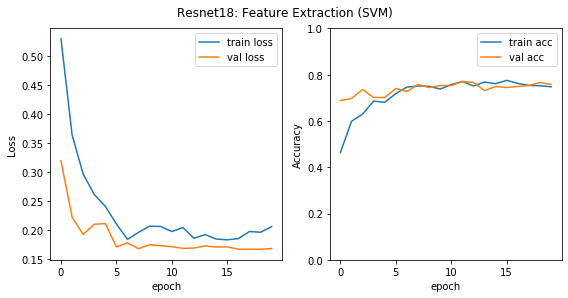

In [60]:
# Save
model_save_name = "resnet18_fz_svm.pt"
path = "/content/drive/My Drive/{model_save_name}"
torch.save(model_res18_fz_svm.state_dict(), path)

# Plot
plt.subplots(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(loss_train_res18_fz_svm, label="train loss")
plt.plot(loss_val_res18_fz_svm, label="val loss")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_train_res18_fz_svm, label="train acc")
plt.plot(acc_val_res18_fz_svm, label="val acc")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.tight_layout()
plt.suptitle("Resnet18: Feature Extraction (SVM)", va="bottom")
plt.show()

### 8. Resnet18: Finetuning with Adam optimizer

In [0]:
model_res18_adam = models.resnet18(pretrained=True)
num_ftrs = model_res18_adam.fc.in_features
model_res18_adam.fc = nn.Linear(num_ftrs, len(class_names))
model_res18_adam = model_res18_adam.to(device)

In [47]:
# Decay LR by a factor of 0.1 every 5 epochs
criterion = nn.CrossEntropyLoss()
optimizer_res18_adam = optim.Adam(model_res18_adam.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_res18_adam, step_size=5, gamma=0.1)

loss_train_res18_adam=[]
loss_val_res18_adam=[]
acc_train_res18_adam=[]
acc_val_res18_adam=[]

# Train
model_res18_adam = train_model(model_res18_adam, criterion, optimizer_res18_adam, exp_lr_scheduler,
                       num_epochs=20, loss_train=loss_train_res18_adam, loss_val=loss_val_res18_adam, acc_train=acc_train_res18_adam, acc_val=acc_val_res18_adam)

# Test 
test(model_res18_adam, criterion)


Epoch 0/19
----------
train Loss: 1.2189 Acc: 0.4660
val Loss: 1.1470 Acc: 0.4848

Epoch 1/19
----------
train Loss: 1.0290 Acc: 0.5267
val Loss: 0.5733 Acc: 0.7273

Epoch 2/19
----------
train Loss: 0.8604 Acc: 0.5959
val Loss: 0.6216 Acc: 0.7229

Epoch 3/19
----------
train Loss: 0.8332 Acc: 0.6153
val Loss: 0.6272 Acc: 0.6970

Epoch 4/19
----------
train Loss: 0.7392 Acc: 0.6723
val Loss: 0.4280 Acc: 0.8398

Epoch 5/19
----------
train Loss: 0.5558 Acc: 0.7731
val Loss: 0.3159 Acc: 0.8918

Epoch 6/19
----------
train Loss: 0.4852 Acc: 0.8143
val Loss: 0.2962 Acc: 0.8874

Epoch 7/19
----------
train Loss: 0.4794 Acc: 0.8204
val Loss: 0.3001 Acc: 0.8874

Epoch 8/19
----------
train Loss: 0.3720 Acc: 0.8629
val Loss: 0.2490 Acc: 0.8831

Epoch 9/19
----------
train Loss: 0.3540 Acc: 0.8580
val Loss: 0.2633 Acc: 0.8961

Epoch 10/19
----------
train Loss: 0.3347 Acc: 0.8750
val Loss: 0.2381 Acc: 0.9134

Epoch 11/19
----------
train Loss: 0.3209 Acc: 0.8896
val Loss: 0.2259 Acc: 0.9134

Ep

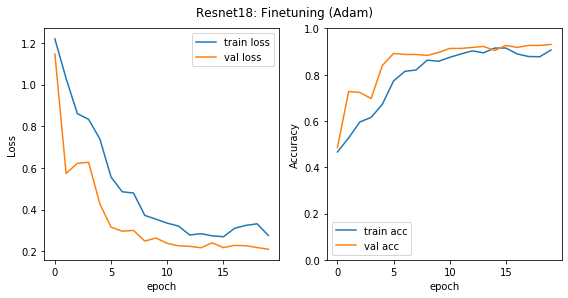

In [61]:
# Save
model_save_name = "resnet18_adam.pt"
path = "/content/drive/My Drive/{model_save_name}"
torch.save(model_res18_adam.state_dict(), path)

# Plot
plt.subplots(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(loss_train_res18_adam, label="train loss")
plt.plot(loss_val_res18_adam, label="val loss")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_train_res18_adam, label="train acc")
plt.plot(acc_val_res18_adam, label="val acc")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.tight_layout()
plt.suptitle("Resnet18: Finetuning (Adam)", va="bottom")
plt.show()

### 9. Resnet18: Feature Extraction with Adam optimizer

In [0]:
model_res18_fz_adam = models.resnet18(pretrained=True)
for param in model_res18_fz_adam.parameters():
  param.requires_grad = False

num_ftrs = model_res18_fz_adam.fc.in_features
model_res18_fz_adam.fc = nn.Linear(num_ftrs, len(class_names))
model_res18_fz_adam = model_res18_fz_adam.to(device)

In [50]:
# Decay LR by a factor of 0.1 every 5 epochs
criterion = nn.CrossEntropyLoss()
optimizer_res18_fz_adam = optim.Adam(model_res18_fz_adam.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_res18_fz_adam, step_size=5, gamma=0.1)

loss_train_res18_fz_adam=[]
loss_val_res18_fz_adam=[]
acc_train_res18_fz_adam=[]
acc_val_res18_fz_adam=[]

# Train
model_res18_fz_adam = train_model(model_res18_fz_adam, criterion, optimizer_res18_fz_adam, exp_lr_scheduler,
                       num_epochs=20, loss_train=loss_train_res18_fz_adam, loss_val=loss_val_res18_fz_adam, acc_train=acc_train_res18_fz_adam, acc_val=acc_val_res18_fz_adam)

# Test 
test(model_res18_fz_adam, criterion)


Epoch 0/19
----------
train Loss: 1.2217 Acc: 0.4345
val Loss: 0.9105 Acc: 0.6580

Epoch 1/19
----------
train Loss: 0.9701 Acc: 0.6019
val Loss: 0.7855 Acc: 0.6667

Epoch 2/19
----------
train Loss: 0.8513 Acc: 0.6432
val Loss: 0.6878 Acc: 0.6710

Epoch 3/19
----------
train Loss: 0.7742 Acc: 0.6650
val Loss: 0.6949 Acc: 0.7013

Epoch 4/19
----------
train Loss: 0.6961 Acc: 0.7379
val Loss: 0.7125 Acc: 0.6926

Epoch 5/19
----------
train Loss: 0.6834 Acc: 0.7184
val Loss: 0.5914 Acc: 0.7359

Epoch 6/19
----------
train Loss: 0.6472 Acc: 0.7755
val Loss: 0.5881 Acc: 0.7403

Epoch 7/19
----------
train Loss: 0.6630 Acc: 0.7500
val Loss: 0.5799 Acc: 0.7532

Epoch 8/19
----------
train Loss: 0.6781 Acc: 0.7536
val Loss: 0.5838 Acc: 0.7403

Epoch 9/19
----------
train Loss: 0.6371 Acc: 0.7706
val Loss: 0.5946 Acc: 0.7532

Epoch 10/19
----------
train Loss: 0.6944 Acc: 0.7233
val Loss: 0.5729 Acc: 0.7359

Epoch 11/19
----------
train Loss: 0.6740 Acc: 0.7367
val Loss: 0.5660 Acc: 0.7489

Ep

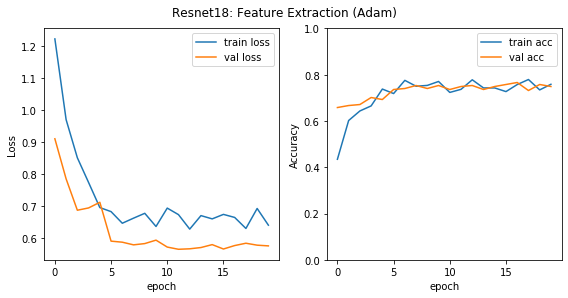

In [62]:
# Save
model_save_name = "resnet18_fz_adam.pt"
path = "/content/drive/My Drive/{model_save_name}"
torch.save(model_res18_fz_adam.state_dict(), path)

# Plot
plt.subplots(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(loss_train_res18_fz_adam, label="train loss")
plt.plot(loss_val_res18_fz_adam, label="val loss")
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(acc_train_res18_fz_adam, label="train acc")
plt.plot(acc_val_res18_fz_adam, label="val acc")
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.tight_layout()
plt.suptitle("Resnet18: Feature Extraction (Adam)", va="bottom")
plt.show()